# StreamBasedCache

## Install dependencies

In [1]:
try:
    import google.colab
    GOOGLE_COLAB = True
except ImportError:
    GOOGLE_COLAB = False

In [2]:
if GOOGLE_COLAB:
    !sudo apt-get -yqq install libsnappy-dev

In [3]:
if GOOGLE_COLAB:
    !pip install -q python-snappy Faker pyproj
    !pip install -q -U bokeh

In [4]:
if GOOGLE_COLAB:
    !pip install "git+https://github.com/ostrokach/beam.git@feature/streambasedcache#egg=apache_beam[gcp]&subdirectory=sdks/python"

## Imports

In [115]:
from __future__ import print_function

import copy
import itertools
import json
import logging
import os
import pickle
import shutil
import tempfile
import time
import uuid
from datetime import datetime

import numpy as np
import pandas as pd
import pytz
import requests
import tqdm
from faker import Faker
from google.api_core import exceptions as gexc
from google.cloud import pubsub

import apache_beam as beam
import pyproj
from apache_beam.io.filesystems import FileSystems
from apache_beam.io.gcp.pubsub import PubsubMessage
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.runners.direct.direct_runner import BundleBasedDirectRunner
from apache_beam.runners.interactive import caching
from apache_beam.transforms import combiners
from apache_beam.transforms import window
from apache_beam.transforms.ptransform import ptransform_fn
from bokeh.io import output_notebook
from bokeh.io import push_notebook
from bokeh.io import show
from bokeh.layouts import row
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

In [78]:
pd.set_option("max_columns", 100)

In [79]:
%matplotlib inline

## Parameters

In [6]:
if GOOGLE_COLAB:
    from google.colab import auth
    auth.authenticate_user()

In [7]:
#@title Google Cloud Project Info { display-mode: "form" }
project_id = "strokach-playground" #@param {type:"string"}
gcs_temp_location = "gs://strokach/dataflow_temp" #@param {type:"string"}

In [28]:
NOTEBOOK_NAME = "streambasedcache_chicago"
try:
    os.mkdir(NOTEBOOK_NAME)
except OSError:
    pass

In [8]:
options = PipelineOptions(
    temp_location=gcs_temp_location, streaming=True, project=project_id
)
options.display_data()

{'project': 'strokach-playground',
 'streaming': True,
 'temp_location': 'gs://strokach/dataflow_temp'}

In [9]:
try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    print("No autoreload")

## Dataset

### Load data

In [21]:
def download_file(url, outfile):
    local_filename = url.split('/')[-1]
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    return local_filename

In [24]:
try:
    chicago_taxi_trips_2018_12 = pd.read_csv("chicago_taxi_trips_2018_12.csv.gz")
except OSError:
    local_filename = download_file("https://storage.googleapis.com/strokach/inputs/chicago_taxi_trips_2018_12.csv.gz")
    chicago_taxi_trips_2018_12 = pd.read_csv(local_filename)

In [26]:
try:
    chicago_taxi_trips_2019_01 = pd.read_csv("chicago_taxi_trips_2019_01.csv.gz")
except IOError:
    local_filename = download_file("https://storage.googleapis.com/strokach/inputs/chicago_taxi_trips_2019_01.csv.gz")
    chicago_taxi_trips_2019_01 = pd.read_csv(local_filename)

### Validate data

In [ ]:
# Make sure that latilatitude and longitude columns have the same info as location columns
df1 = chicago_taxi_trips_2018_12[
    (~chicago_taxi_trips_2018_12[["pickup_location", "dropoff_location"]].isnull().any(axis=1))
]

df2 = chicago_taxi_trips_2018_12[
    (~chicago_taxi_trips_2018_12[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]].isnull().any(axis=1))
]

assert (df1.index == df2.index).all()

In [44]:
# Make sure that latilatitude and longitude columns have the same info as location columns
df1 = chicago_taxi_trips_2019_01[
    (~chicago_taxi_trips_2019_01[["pickup_location", "dropoff_location"]].isnull().any(axis=1))
]

df2 = chicago_taxi_trips_2019_01[
    (~chicago_taxi_trips_2019_01[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]].isnull().any(axis=1))
]

assert (df1.index == df2.index).all()

In [152]:
df1.head(10)

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
30434,3503491546ea35b9bf64cceab1f0f8ebbb1211ca,9b9e44c129b4382098a2bceccf6f941ee1bf1d25c7b24d...,2019-01-03 22:30:00 UTC,2019-01-03 22:30:00 UTC,0.0,0.1,NaN,NaN,14.0,14.0,3.25,0.0,0.0,0.00,3.25,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
30435,3905c941525143a58474a553a0cb961495eb0643,0300862a19483bcacac6176544abf331b8a3d41ec6efda...,2019-01-03 23:30:00 UTC,2019-01-03 23:45:00 UTC,960.0,0.3,NaN,NaN,14.0,14.0,16.50,0.0,0.0,0.00,16.50,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
30436,687e88069fad32d5b4f699d1aeb588ff9f419313,084b422a6d13f5d6b7be4a235cb6cc68363b39f24536de...,2019-01-07 02:15:00 UTC,2019-01-07 02:15:00 UTC,60.0,0.1,NaN,NaN,14.0,14.0,3.50,0.0,0.0,0.00,3.50,Cash,Star North Management LLC,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
30437,8c99c7a132cea16e4044433d3372a5a5a214fca8,6ff21e0bab9e23cdc8e918e8c55155fa3568ad81f587fd...,2019-01-04 19:00:00 UTC,2019-01-04 19:00:00 UTC,0.0,0.0,NaN,NaN,14.0,14.0,3.25,0.0,0.0,0.00,3.25,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
30438,09ec5b111476edd67c004af97938f8795747a7fd,ad7483003b6f955fcbcf74d4c9273fc13d97df1755f0b6...,2019-01-04 16:00:00 UTC,2019-01-04 16:00:00 UTC,0.0,0.0,NaN,NaN,14.0,14.0,3.50,0.0,0.0,1.00,4.50,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
30439,e01beedebbe6439eed587ce3d3eff58ba48e99a7,9b9e44c129b4382098a2bceccf6f941ee1bf1d25c7b24d...,2019-01-04 04:15:00 UTC,2019-01-04 04:15:00 UTC,120.0,0.6,NaN,NaN,14.0,14.0,4.75,0.0,0.0,20.25,25.00,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
30440,d3cdf65becbc30c6bf1aadd062d149fe6ca41625,f5eb0a822a607eab0ed4a970d1ccc3728a500fe45f7476...,2019-01-06 22:45:00 UTC,2019-01-06 22:45:00 UTC,0.0,0.0,NaN,NaN,14.0,14.0,48.00,0.0,0.0,0.00,48.00,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
30441,8183563835ad47935cf661ccf404f453e0b02f68,96213b45ac0c57840ec7676675c8f2a4caea942579445b...,2019-01-04 16:45:00 UTC,2019-01-04 16:45:00 UTC,0.0,0.0,NaN,NaN,14.0,14.0,3.25,0.0,0.0,0.00,3.25,Cash,Star North Management LLC,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
30442,a227226a9ba99a3fcff435192d28d59cbca8ce92,86eaf7c8b40d86769f267110d1dd80ef7bffc9b060bde7...,2019-01-07 10:15:00 UTC,2019-01-07 10:30:00 UTC,300.0,0.9,NaN,NaN,14.0,14.0,5.75,2.0,0.0,1.00,8.75,Credit Card,Star North Management LLC,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)
30443,6ba1b693a2641a057b66b56e2f6c51dd570f2b79,cea53c687c3dd5ab8ad7483cc0003e4ea755d879919588...,2019-01-07 04:45:00 UTC,2019-01-07 04:45:00 UTC,0.0,0.0,NaN,NaN,14.0,14.0,3.25,0.0,0.0,0.00,3.25,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069)


### Create `events_df`

In [ ]:
nonull_columns = [
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
]

events = []

for i, row in enumerate(
    itertools.chain(
        chicago_taxi_trips_2018_12[
            chicago_taxi_trips_2018_12[nonull_columns].notnull().all(axis=1)
        ].itertuples(),
        chicago_taxi_trips_2019_01[
            chicago_taxi_trips_2019_01[nonull_columns].notnull().all(axis=1)
        ].itertuples(),
    )
):
    start_event = {
        "index": i,
        "event_type": "start",
        "unique_key": row.unique_key,
        "taxi_id": row.taxi_id,
        "timestamp": row.trip_start_timestamp,
        "latitude": row.pickup_latitude,
        "longitude": row.pickup_longitude,
    }

    stop_event = {
        "index": i,
        "event_type": "stop",
        "unique_key": row.unique_key,
        "taxi_id": row.taxi_id,
        "timestamp": row.trip_end_timestamp,
        "latitude": row.dropoff_latitude,
        "longitude": row.dropoff_longitude,
        "trip_seconds": row.trip_seconds,
        "trip_miles": row.trip_miles,
        "trip_total": row.trip_total,
    }

    events.extend([start_event, stop_event])


events_columns = [
    "index",
    "event_type",
    "unique_key",
    "taxi_id",
    "timestamp",
    "latitude",
    "longitude",
    "trip_seconds",
    "trip_miles",
    "trip_total",
]
events_df = pd.DataFrame(events, columns=events_columns)

In [153]:
events_df.head()

,index,event_type,unique_key,taxi_id,timestamp,latitude,longitude,trip_seconds,trip_miles,trip_total,timestamp_seconds,year,month,day,hour,minute,second,utm_x,utm_y
1086769,543384,stop,5a089fd828e6846a24f0d3eb2fe04ec4ca1b935b,8edce7ce70dba32066bbc7eed40b32a7602db0ceb6bb1d...,2016-11-05 16:15:00 UTC,41.880994,-87.632746,NaN,17.7,36.65,1.478362e+09,2016,11,5,11,15,0,-9.755233e+06,5.143170e+06
2443501,1221750,stop,7a6acc59395b80f8cd0394f3856246a624e28874,2c9e6892a16411ee7efb69f8b6dc4040e9b3347b4799ee...,2018-11-30 00:00:00 UTC,41.914586,-87.645966,NaN,0.0,700.04,1.543536e+09,2018,11,29,18,0,0,-9.756704e+06,5.148193e+06
330285,165142,stop,8c30a1411fb68bd2c2b433b9b30c83dcd5b7b7d0,9fb94ceaab8c4ba0476f7dce462b8965841f7848dfb81d...,2018-12-01 00:00:00 UTC,41.879067,-87.657005,360.0,1.4,9.25,1.543622e+09,2018,11,30,18,0,0,-9.757933e+06,5.142881e+06
1280977,640488,stop,fbaa54489525d56c159e5b159dc3e92fdaace454,09b0865d5ad0def4383fb26a206bacb9f84342269d4f30...,2018-12-01 00:00:00 UTC,41.879255,-87.642649,180.0,1.2,6.25,1.543622e+09,2018,11,30,18,0,0,-9.756335e+06,5.142910e+06
1280976,640488,start,fbaa54489525d56c159e5b159dc3e92fdaace454,09b0865d5ad0def4383fb26a206bacb9f84342269d4f30...,2018-12-01 00:00:00 UTC,41.877406,-87.621972,NaN,NaN,NaN,1.543622e+09,2018,11,30,18,0,0,-9.754033e+06,5.142633e+06


In [156]:
from collections import Counter

c = Counter([tuple(ll) for ll in events_df[["latitude", "longitude"]].values])

In [158]:
counts = pd.DataFrame([key + (value,) for key, value in c.items()], columns=["latitude", "longitude", "count"]).sort_values("count")

In [161]:
import matplotlib.pyplot as plt

Text(0.5,1,'Chicago - December 2018 / January 2019')

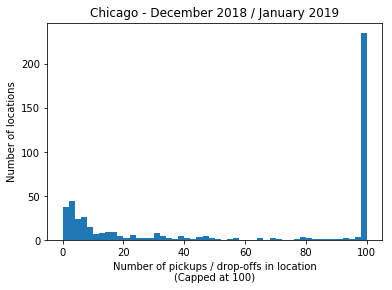

In [186]:
plt.hist(np.clip(counts["count"], 0, 100), range=(0, 100), bins=50)
plt.xlabel("Number of pickups / drop-offs in location\n(Capped at 100)")
plt.ylabel("Number of locations")
plt.title("Chicago - December 2018 / January 2019")

### Add `timestamp_seconds` column

In [138]:
def timestamp_to_seconds(timestamp_str):
    from datetime import datetime
    import pytz

    dt = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S UTC")
    dt = dt.replace(tzinfo=pytz.UTC)  # .astimezone(pytz.timezone('America/Chicago'))
    unix_dt = datetime.utcfromtimestamp(0).replace(tzinfo=pytz.UTC)
    dt_delta = (dt - unix_dt).total_seconds()
    return dt_delta

timestamp_to_seconds("2018-12-06 00:00:00 UTC")

1544054400.0

In [77]:
events_df["timestamp_seconds"] = events_df["timestamp"].apply(timestamp_to_seconds)

In [146]:
events_df["utm_x"], events_df["utm_y"] = list(
    zip(
        *[
            geographic_to_utm(*ll)
            for ll in tqdm.tqdm_notebook(
                events_df[["longitude", "latitude"]].values, total=len(events_df)
            )
        ]
    )
)

### Sort events

In [81]:
events_df = events_df.sort_values("timestamp_seconds", ascending=True)

## Functions

In [144]:
def expand_timestamp(timestamp_str):
    from datetime import datetime

    dt = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S UTC")
    dt = dt.replace(tzinfo=pytz.UTC).astimezone(pytz.timezone('America/Chicago'))
    return dt

expand_timestamp("2018-12-06 00:00:00 UTC")

datetime.datetime(2018, 12, 5, 18, 0, tzinfo=<DstTzInfo 'America/Chicago' CST-1 day, 18:00:00 STD>)

In [145]:
def geographic_to_utm(longitude, latitude, _cache={}):
    if (longitude, latitude) in _cache:
        return _cache[(longitude, latitude)]

    from pyproj import Proj, transform

    x, y = transform(
        Proj(init="epsg:4326"), Proj(init="epsg:3857"), longitude, latitude
    )

    _cache[(longitude, latitude)] = (x, y)
    return x, y


geographic_to_utm(-87.632746, 41.880994)

(-9755232.661536282, 5143169.558268635)

## Workflow

In [87]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.tile_providers import Vendors, get_provider
from bokeh.models.annotations import Title

In [84]:
LONGITUDE_RANGE = events_df["longitude"].min(), events_df["longitude"].max()
LATITUDE_RANGE = events_df["latitude"].min(), events_df["latitude"].max()

x_min, y_min = geographic_to_utm(longitude=LONGITUDE_RANGE[0], latitude=LATITUDE_RANGE[0])
x_max, y_max = geographic_to_utm(longitude=LONGITUDE_RANGE[1], latitude=LATITUDE_RANGE[1])

MERCATOR_X_RANGE = (x_min, x_max)
MERCATOR_Y_RANGE = (y_min, y_max)

In [136]:
from bokeh.io import output_notebook
from bokeh.io import push_notebook
from bokeh.io import show
from bokeh.layouts import row
from bokeh.models import ColumnDataSource
from bokeh.models import Label
from bokeh.models import LabelSet
from bokeh.models import Range1d
from bokeh.models.annotations import Title
from bokeh.plotting import figure
from bokeh.plotting import output_file
from bokeh.plotting import show
from bokeh.tile_providers import Vendors
from bokeh.tile_providers import get_provider

output_notebook()

if GOOGLE_COLAB:
    print("Interactive plot does not work on colab yet!")

# range bounds supplied in web mercator coordinates
fig = figure(
    x_range=MERCATOR_X_RANGE,
    y_range=MERCATOR_Y_RANGE,
    x_axis_type="mercator",
    y_axis_type="mercator",
    #     title_location="left"
    #     plot_height=600,
)
fig.add_tile(get_provider(Vendors.CARTODBPOSITRON))

source = ColumnDataSource(data=dict(x=[], y=[]))

fig.circle(x="x", y="y", size=2, fill_color="blue", fill_alpha=0.8, source=source)

handle = show(fig, notebook_handle=True)

for index, gp in events_df.sample(frac=0.1).groupby(["timestamp"]):
    print(index)
    print('0')
    gp = gp.copy()
    print('1')
    gp["utm_x"], gp["utm_y"] = list(
        zip(*[geographic_to_utm(*ll) for ll in gp[["longitude", "latitude"]].values])
    )
    print('a')
    fig.title.text = index
    fig.title.align = "center"
    print('b')
    source.data = {"x": gp["utm_x"].values, "y": gp["utm_y"].values}
    print('c')
    push_notebook(handle=handle)
#     time.sleep(1)
#     break

# while True:
#     for i, row in enumerate(temp.read()):
#         title = Title()
#         title.text = row[0].strftime("%Y-%m-%d %H:%M:%S")
#         fig.title = title
#         source.stream({"x": [e["x"] for e in row[1]], "y": [e["y"] for e in row[1]]})
#         push_notebook(handle=handle)

Loading BokehJS ...

2018-12-01 00:00:00 UTC
0
1
a
b
c
2018-12-01 00:15:00 UTC
0
1
a
b
c
2018-12-01 00:30:00 UTC
0
1
a
b
c
2018-12-01 00:45:00 UTC
0
1


KeyboardInterrupt: 

### Write dataset to cache

In [21]:
sub_client = pubsub.SubscriberClient()

In [22]:
subscription_name = "projects/{}/subscriptions/taxirides-realtime-sub".format(project_id)

try:
    sub_client.create_subscription(
        subscription_name,
        "projects/pubsub-public-data/topics/taxirides-realtime",
    )
except gexc.AlreadyExists:
    sub_client.delete_subscription(subscription_name)
    sub_client.create_subscription(
        subscription_name,
        "projects/pubsub-public-data/topics/taxirides-realtime",
    )

### Process data from subscription to cache

In [43]:
LONGITUDE_RANGE = (-74.747, -73.969)  # (-74.07, -73.90)
LATITUDE_RANGE = (40.699, 40.720)  # (40.73, 40.77)

In [50]:
x_min, y_min = geographic_to_utm(longitude=LONGITUDE_RANGE[0], latitude=LATITUDE_RANGE[0])
x_max, y_max = geographic_to_utm(longitude=LONGITUDE_RANGE[1], latitude=LATITUDE_RANGE[1])

MERCATOR_X_RANGE = (x_min, x_max)
MERCATOR_Y_RANGE = (y_min, y_max)

In [25]:
raise Exception

Exception: 

In [72]:
try:
    p_result.cancel()
except NameError:
    pass

In [73]:
temp = caching.PubSubBasedCache(
    "projects/{}/topics/temp-2".format(project_id), mode="overwrite"
)

In [74]:
class ToList(beam.PTransform):
  """A global CombineFn that condenses a PCollection into a single list."""

  def __init__(self, label='ToList'):  # pylint: disable=useless-super-delegation
    super(ToList, self).__init__(label)

  def expand(self, pcoll):
    return pcoll | self.label >> beam.CombineGlobally(combiners.ToListCombineFn()).without_defaults()


In [75]:
class BuildRecordFn(beam.DoFn):
    def __init__(self):
        super(BuildRecordFn, self).__init__()

    def process(self, elements, window=beam.DoFn.WindowParam):
        # window_start = window.start.to_utc_datetime()
        window_end = window.end.to_utc_datetime()
        return [(window_end, elements)]

In [76]:
p = beam.Pipeline(runner=BundleBasedDirectRunner(), options=options)

out = (
    p
    | "Read" >> beam.io.ReadFromPubSub(subscription=subscription_name, with_attributes=True)
#     | "echo" >> beam.Map(lambda e: print(e) or e)
    | "Decode PubSub message" >> beam.ParDo(DecodeTaxiMessage())
    | "Load JSON" >> beam.Map(load_json)
    | "Filter coords" >> beam.ParDo(SelectWithinGeographicRange(LONGITUDE_RANGE, LATITUDE_RANGE))
    | "Add UTM coords" >> beam.Map(add_mercator_coords)
    | "Window" >> beam.WindowInto(window.FixedWindows(2 * 60))
    | "Combine" >> ToList()
    | 'AddWindowEndTimestamp' >> beam.ParDo(BuildRecordFn())
#     | "echo" >> beam.Map(lambda e: print(e) or e)
    | "Write" >> temp.writer()
)

p_result = p.run()

In [77]:
for row in itertools.islice(temp.read(), 2):
    print(row)

(datetime.datetime(2019, 7, 2, 22, 16), [{'ride_id': '2a1e8f6e-dcd2-45aa-8e1d-59cdddc27c3d', 'ride_status': 'enroute', 'timestamp': '2019-07-02T18:14:24.01675-04:00', 'point_idx': 83, 'longitude': -73.9791, 'latitude': 40.71998000000001, 'passenger_count': 1, 'meter_increment': 0.029901959, 'meter_reading': 2.4818625, 'y': 4971126.102924636, 'x': -8235315.741344665}])
(datetime.datetime(2019, 7, 2, 22, 16), [{'ride_id': '0c309d27-4a54-440f-8a8b-60f9ac5fd341', 'ride_status': 'enroute', 'timestamp': '2019-07-02T18:15:39.96543-04:00', 'point_idx': 749, 'longitude': -74.00422, 'latitude': 40.70546, 'passenger_count': 1, 'meter_increment': 0.024694046, 'meter_reading': 18.49584, 'y': 4968993.673761639, 'x': -8238112.086953393}])


In [85]:
row[0].strftime("%Y-%m-%d %H:%M:%S")

'2019-07-02 22:16:00'

### Interactive dashboard

In [ ]:
import logging

logging.getLogger("google.auth._default").setLevel(logging.CRITICAL)

In [89]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.tile_providers import Vendors, get_provider
from bokeh.models.annotations import Title

In [88]:
bokeh.plotting.

In [92]:
output_notebook()

if GOOGLE_COLAB:
    print("Interactive plot does not work on colab yet!")

# range bounds supplied in web mercator coordinates
fig = figure(
    x_range=MERCATOR_X_RANGE,
    y_range=MERCATOR_Y_RANGE,
    x_axis_type="mercator",
    y_axis_type="mercator",
#     plot_height=600,
)
fig.add_tile(get_provider(Vendors.CARTODBPOSITRON))

source = ColumnDataSource(data=dict(x=[], y=[]))

fig.circle(x="x", y="y", size=2, fill_color="blue", fill_alpha=0.8, source=source)

handle = show(fig, notebook_handle=True)

while True:
    for i, row in enumerate(temp.read()):
        title = Title()
        title.text = row[0].strftime("%Y-%m-%d %H:%M:%S")
        fig.title = title
        source.stream({"x": [e["x"] for e in row[1]], "y": [e["y"] for e in row[1]]})
        push_notebook(handle=handle)

Loading BokehJS ...

KeyboardInterrupt: 

Exception KeyboardInterrupt in 'grpc._cython.cygrpc._next' ignored


KeyError: None